In [1]:
var openDigger = require('../src/open_digger');

# Notebook handbook

This is an example notebook of OpenDigger to show how to use OpenDigger to analysis open source data.

## Function Groups

There are several function groups you can use to get data from OpenDigger, like `render`, `label`, `quick`, `index`, `metric`, `relation`, `driver`.

### Render

As we use JupyterLab to analysis the data, we provide the [`plotyly`](https://plotly.com/javascript/) interface to draw the graphs.

You can access plotly function like `openDigger.render.plotly(data, config)`;

As for drawing table, you can directly use `console.table` of Node.js.

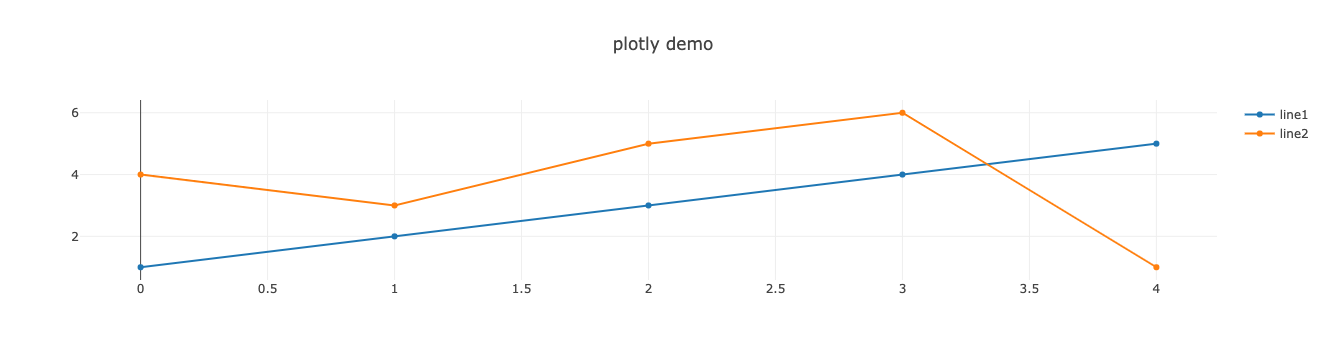

┌─────────┬────────┬───────┐
│ (index) │  name  │ score │
├─────────┼────────┼───────┤
│    0    │ 'John' │  2.4  │
│    1    │ 'Lily' │  3.2  │
└─────────┴────────┴───────┘


In [2]:
openDigger.render.plotly([{y: [1,2,3,4,5],name: 'line1'}, {y: [4,3,5,6,1],name: 'line2'}], {title: 'plotly demo'});
console.table([{name: 'John', score:2.4}, {name: 'Lily',score: 3.2}]);

### Label

In OpenDigger, we have lots of labeled data for repositories like Company, Foundation, China and etc.

You can use `openDigger.label.getLabelData()` to get all the labels and use `openDigger.label.getGitHubData(typeOrIds: string[])` to get GitHub data of certain labels.

The `openDigger.label.getLabelData()` will return an array with item structure like:

``` javascript
{
    identifier: string;     // The identifier of the label, like :companies/alibaba or :foundations/apache
    type: string;           // The type of the label, like Company or Foundation
    name: string;           // Name of the label, like Alibaba or Apache Software Foundation
    githubRepos: number[];  // GitHub repository ids under this label
    githubOrgs: number[];   // GitHub organization ids under this label
    githubUsers: number[];  // GitHub user ids under this label
}
```

The `openDigger.label.getGitHubData(typeOrIds: string[])` function accepts an array with label identifiers or types to get all the repository, organization and user ids under the labels.

In [3]:
var labelData = openDigger.label.getLabelData();
console.log(`OpenDigger has ${labelData.length} labels with ${new Set(labelData.map(l => l.type)).size} types`);

OpenDigger has 77 labels with 5 types


In [4]:
var data = openDigger.label.getGitHubData(['Foundation', 'Company']);
console.log(`There are ${data.githubRepos.length} repos and ${data.githubOrgs.length} orgs for all foundation and company labels`);

There are 149 repos and 234 orgs for all foundation and company labels


### Quick

#### showAll

`openDigger.quick.showAll(repoName: string, startYear: number = 2015, endYear: number = 2021)` is a powerful function to show all the activity and openrank data in between `startYear` and `endYear` for repository `repoName`.

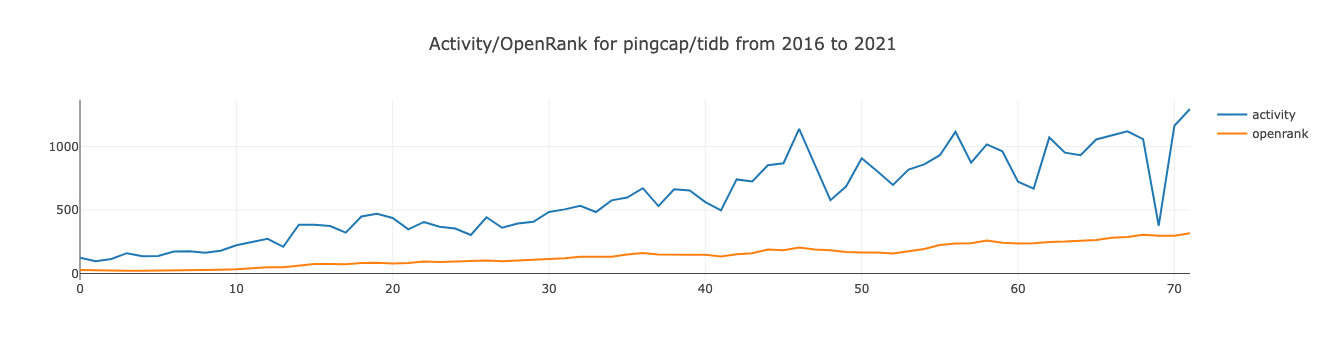

In [5]:
openDigger.quick.showAll('pingcap/tidb', 2016);

### Index

In OpenDigger, we provide indexe implementations for users to dive into the data.

#### Activity Index

Activity index is the basic inde introduced by X-lab, activity index uses `IssueCommentEvent`, `IssuesEvent`, `PullRequestEvent` and `PullRequestReviewCommentEvent` in GitHub event log.

You can use `openDigger.index.activity.getRepoActivity(config)` to get activity index of certain projects.

The `config` structure is like below:

``` javascript
{
    labelUnion?: string[];                       // use to get all repos have any label in the array
    labelIntersect?: string[];                   // use to get all repos have all the labels in the array
    repoIds?: number[];                          // specific repo id array
    repoNames?: string[];                        // specific repo name array
    orgIds?: number[];                           // specific org id array
    orgNames?: string[];                         // specific org name array
    userIds?: number[];                          // specific user id array, used in user query
    userLogins?: string[];                       // specific user login array, used in user query
    startYear?: number = 2015;                   // start year of the data, default: 2015
    startMonth?: number = 1;                     // start month of the data, default: 1
    endYear?: number = current_year;             // end year of the data, default: current year
    endMonth?: number = last_month;              // end month of the data, default: last month 
    order?: 'DESC' | 'ASC' = 'DESC';             // return data order by DESC or ASC, default: DESC
    limit?: number = 10;                         // the limit of return records, default: 10
    percision?: number = 2;                      // the percision of the float number like activity or openrank, default: 2
    groupBy?: 'org' | string;                    // how to group repos, by org or any label type like Company. default: null, return by repo
    groupTimeRange?: 'month' | 'season' | 'year';// how to group by time, by month, season or year, default: null, return all data in a row
}
```

> ***This config will be used for all index and metrics query.***

It may suit all the data analysis needs by modify the config.

- getRepoActivity

This function will return the repo activity with the config param.

Here is an example of all Chinese projects group by Company and by year from 2015 to 2021.

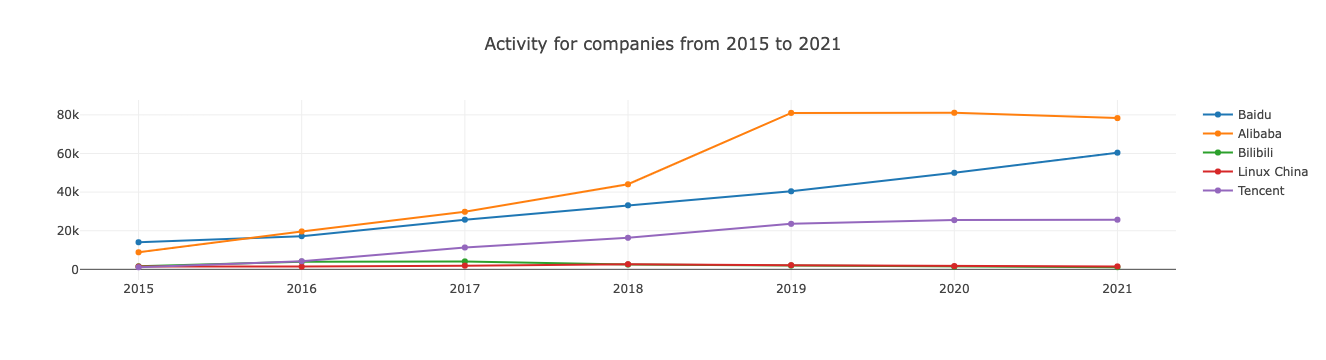

In [6]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.activity.getRepoActivity({labelIntersect: ['Company', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'year', limit: 5}).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.activity, mode: 'scatter', name: row.label };
    }), {title: `Activity for companies from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

- getUserActivity

This function will return the user activity with the config param.

Here is an example of k8s-ci-robot and vscode-triage-bot by year from 2015 to 2021.

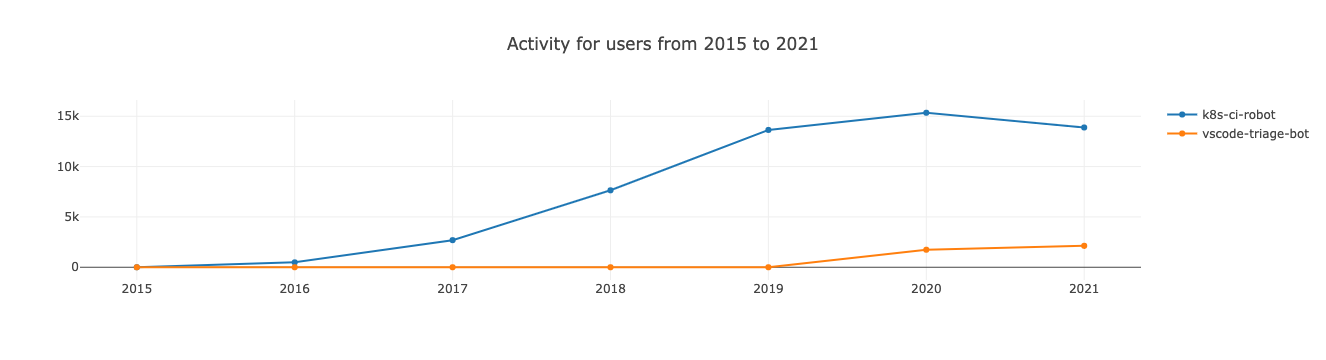

In [7]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.activity.getUserActivity({userLogins: ['k8s-ci-robot', 'vscode-triage-bot'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'year'}).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.activity, mode: 'scatter', name: row.user_login };
    }), {title: `Activity for users from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

#### OpenRank

OpenRank is an index introduced by X-lab, OpenRank uses activity index as foundamental data to generate a global developement network with developers and repos as node and activity relation as edges.

And then use a PageRank-like algorithm with heterogeneous information networks support called HINRank to rank all the developers and repos together to find out which is more important in the open source world.

- getRepoOpenrank

This function will return repo OpenRank with the config param.

Here is an example of all Chinese projects under foundation group by Foundation and by year from 2015 to 2021.

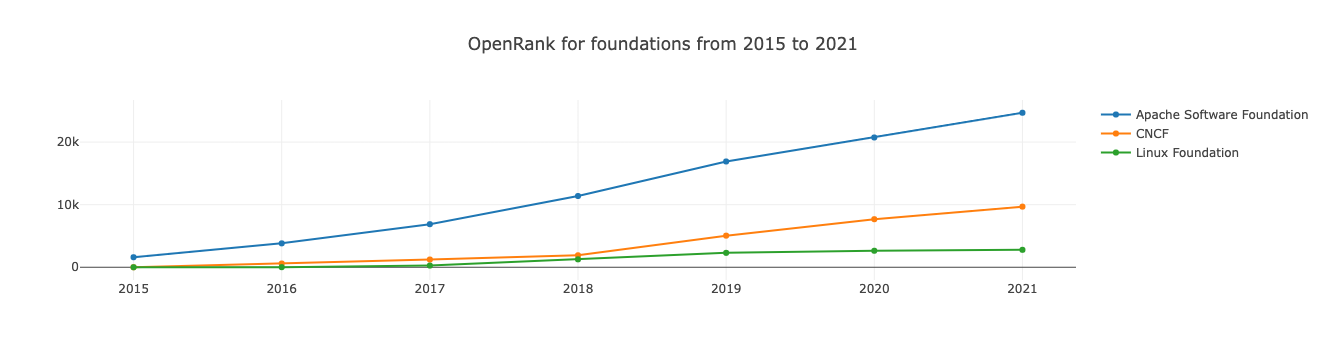

In [9]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.openrank.getRepoOpenrank({labelIntersect: ['Foundation', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Foundation', groupTimeRange: 'year', limit: 5}).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.open_rank, mode: 'scatter', name: row.label };
    }), {title: `OpenRank for foundations from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

- getUserOpenrank

This function will return the user OpenRank with the config param.

Here is an example of k8s-ci-robot and vscode-triage-bot by year from 2015 to 2021.

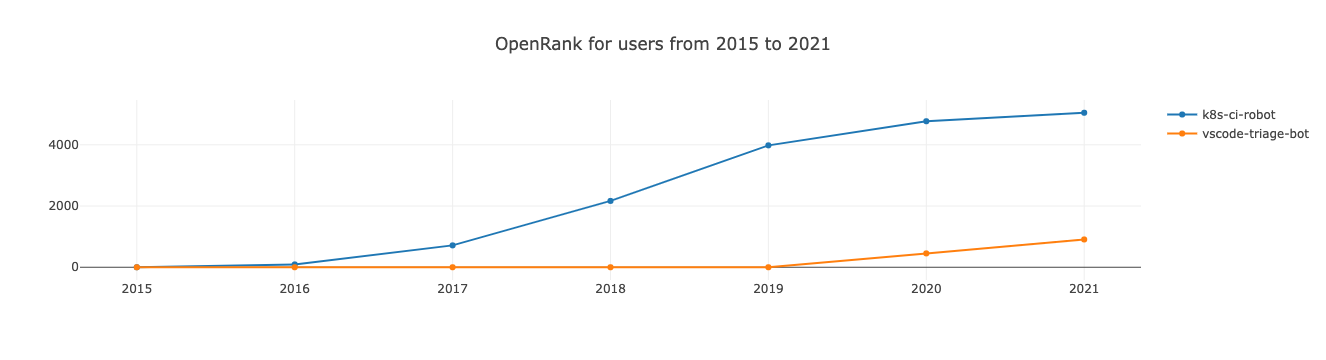

In [9]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.openrank.getUserOpenrank({userLogins: ['k8s-ci-robot', 'vscode-triage-bot'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'year'}).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.open_rank, mode: 'scatter', name: row.user_login };
    }), {title: `OpenRank for users from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

### Metric

OpenDigger also provides lots of metric implementations to dive into repos.

Many metrics are from CHAOSS community.

### Driver

In OpenDigger, we provided two drivers for users to make thier own SQL request and get data directly from the database.

#### Clickhouse

Clickhouse driver is used to access the original GitHub event log data from 2015 to now.

The driver can be accessed by `openDigger.driver.clickhouse` and provide a function `query(:sql)` to query data.

And example of all log count from 2015 to 2021 shows as below.

[
  [ { count: '212221628' } ],
  [ { count: '320726236' } ],
  [ { count: '412942763' } ],
  [ { count: '479185525' } ],
  [ { count: '605544846' } ],
  [ { count: '863415606' } ],
  [ { count: '999233306' } ]
]


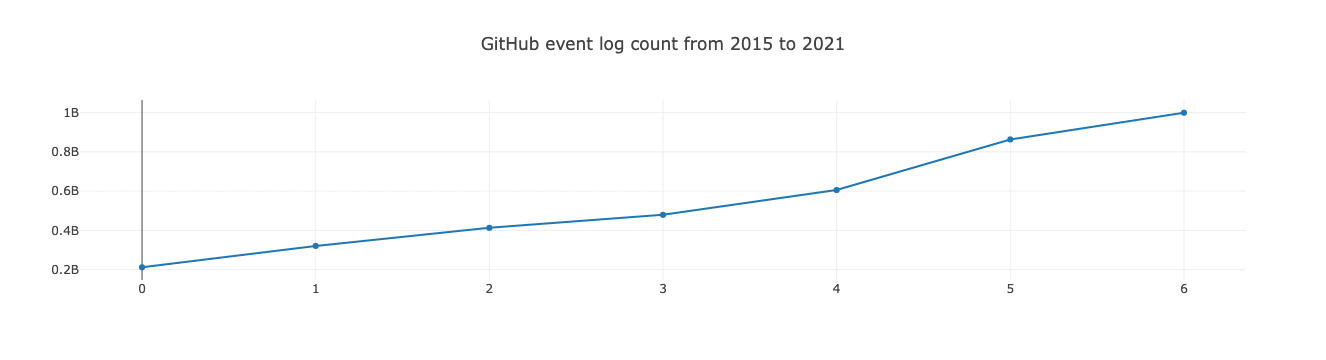

In [11]:
var startYear = 2015, endYear = 2021;
var years = [];
for (var y = startYear; y <= endYear; y++) years.push(y);
Promise.all(years.map(year => {
    return openDigger.driver.clickhouse.query(`SELECT COUNT() AS count FROM github_log.year${year}`);
})).then(data => {
    console.log(data);  // log the result to console
    openDigger.render.plotly([
        {y: data.map(d => d[0].count), mode: 'lines+markers', name: 'log_count'}
    ], {title: `GitHub event log count from ${startYear} to ${endYear}`});  // show the result as image
});

#### Neo4j

Neo4j driver is used to access the graph data with activity and openrank aggregate in month, the date range is identical with clickhouse data.

The driver can be accessed by `openDigger.driver.neo4j` and provide a function `query(:sql,:param)` to query data.

And example of `alibaba` org openrank of 2021 by every month shows as below.

[
  {
    open_rank_20211: 1378.2449947086238,
    open_rank_20212: 1205.9290687883301,
    open_rank_20213: 1198.0659094044643,
    open_rank_20214: 1309.535816358224,
    open_rank_20215: 1217.7917311759222,
    open_rank_20216: 1308.4420165438437,
    open_rank_20217: 1397.4789267862357,
    open_rank_20218: 1341.1264339608747,
    open_rank_20219: 1290.6398701659832,
    open_rank_202110: 869.2497420097089,
    open_rank_202111: 1147.450127156078,
    open_rank_202112: 1340.6250216589958
  }
]


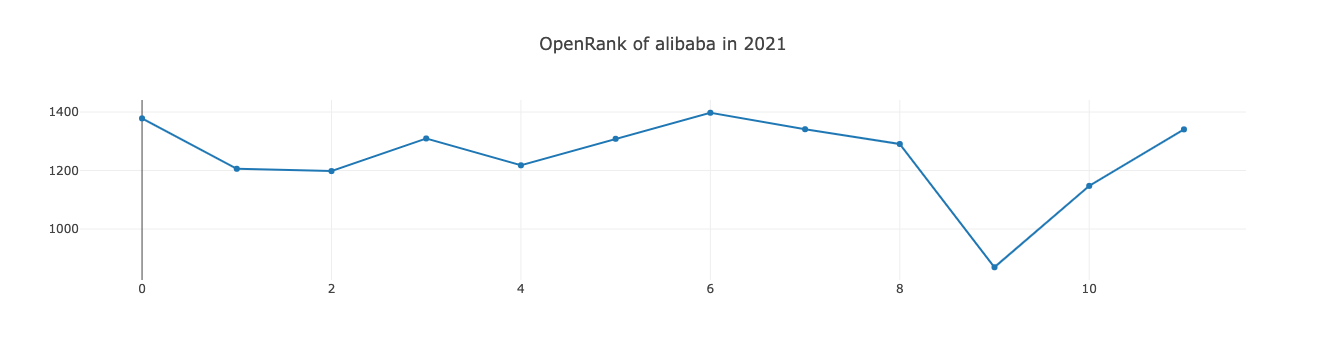

In [12]:
var startMonth = 1, endMonth = 12, org = 'alibaba';
var monthQuery = [];
for (var m = startMonth; m <= endMonth; m++) monthQuery.push(`SUM(COALESCE(r.open_rank_2021${m}, 0.0)) AS open_rank_2021${m}`);
openDigger.driver.neo4j.query(`MATCH (r:Repo) WHERE r.org_login='${org}' RETURN ${monthQuery.join(',')}`).then(data => {
    console.log(data);  // log to console
    openDigger.render.plotly([
        {y: Object.values(data[0]), mode: 'lines+markers', name: 'open_rank'}
    ], {title: `OpenRank of ${org} in 2021`});  // show the result as image
});